In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import (
    error_lidar_pt_vs_truth_pt,
    plot_photon_map,
    plot_tracklines_overview,
)
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from atl_module.plotting import set_size

In [3]:
aoidflist = []
for aoifile in glob("../data/test_sites/oahu*/AOI.gpkg"):
    # get the name of each site
    sitename = aoifile.split("/")[3]
    df = gpd.read_file(aoifile)
    df["site"] = sitename
    aoidflist.append(df)

aoi_combined_df = pd.concat(aoidflist)

aoi_combined_df.to_file('../data/special_sites/oahu_master/aoi')

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [4]:
tracklines_dflist = [
    gpd.read_file(file) for file in glob("../data/test_sites/oahu*/tracklines")
]
tracklines_combined = pd.concat(tracklines_dflist).reset_index()

tracklines_combined.to_file('../data/special_sites/oahu_master/tracks')

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [5]:
dflist = []

for file in glob("../data/test_sites/oahu*/all_bathy_pts.gpkg"):
    df = gpd.read_file(file)
    sitename = file.split("/")[3].strip("oahu")
    df["Subsite"] = sitename
    dflist.append(df)

df = pd.concat(dflist).drop_duplicates().reset_index()

df.to_file('../data/special_sites/oahu_master/bathy_pts')

/home/mlinds/mambaforge/envs/thesis_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_23189/2956502464.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('../data/special_sites/oahu_master/bathy_pts')


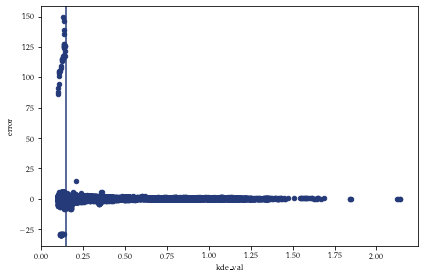

In [6]:
ax = df.plot.scatter(x="kde_val", y="error")
ax.axvline(0.15)

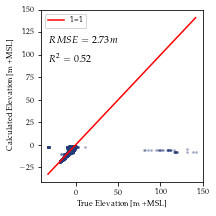

In [7]:
df_nona = df.dropna()
errordict = {
    "RMSE": df_nona.error.pow(2).mean() ** 0.5,
    "R2 Score": r2_score(df_nona.true_elevation, df_nona.sf_elev_MSL),
}
ax = error_lidar_pt_vs_truth_pt(df_nona, errordict,fraction=0.5)
ax.get_figure().savefig(
    "../document/figures/Oahu_combined_lidar_estimated_vs_truth.pdf"
)

del ax

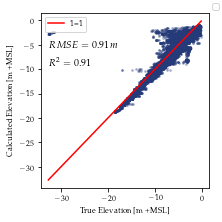

In [8]:
df_nona = df_nona[df_nona.true_elevation < 0]
errordict = {
    "RMSE": df_nona.error.pow(2).mean() ** 0.5,
    "R2 Score": r2_score(df_nona.true_elevation, df_nona.sf_elev_MSL),
}
ax = error_lidar_pt_vs_truth_pt(df_nona, errordict,fraction=0.5)
ax.legend('')
ax.get_figure().savefig(
    "../document/figures/Oahu_combined_mountains_removed_lidar_estimated_vs_truth.pdf"
)

# ax.legend(loc='lower right')


plotting photon map
finished plotting photons
finished adding basemap


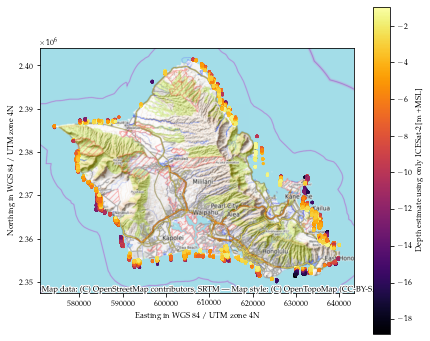

In [9]:
minx, miny, maxx, maxy = df.total_bounds
# this ratio we can feed into the figure sizing function
scale_ratio = (maxx - minx) / (maxy - miny)

fig, ax = plt.subplots(figsize=set_size(fraction=1,ratio=scale_ratio))

plot_photon_map(ax, df)
# artist = df.plot(column='sf_elev_MSL',cmap='inferno',ax=ax,markersize=4)

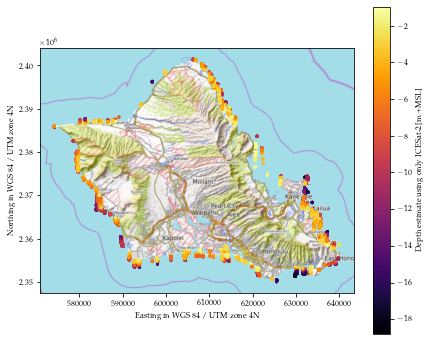

In [10]:
text = fig.axes[0].texts[0]
text.set_visible(False)
text.get_text()
fig.tight_layout()

fig.savefig("../document/figures/Oahu_all_sites_photon_points.pdf",dpi=400)
fig

In [11]:
minx, miny, maxx, maxy = tracklines_combined.total_bounds
# this ratio we can feed into the figure sizing function
scale_ratio = (maxx - minx) / (maxy - miny)
scale_ratio

1.3089821931211385

In [12]:
1/1.618

0.6180469715698392

plotting tracklines
finished plotting tracklines
finished plotting basemap


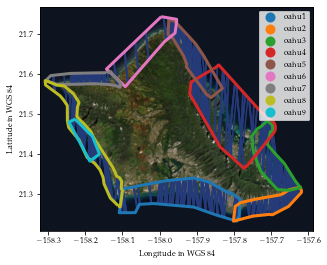

In [13]:
aoi_combined, trackax = plt.subplots(figsize=set_size(fraction = 0.8,ratio=scale_ratio))
plot_tracklines_overview(trackax, tracklines_combined)
aoi_combined_df.plot(
    column="site", categorical=True, legend=True, facecolor="none", lw=3, ax=trackax,zorder=2
)

aoi_combined.axes[0].set_ylabel('Latitude in WGS 84')
aoi_combined.axes[0].set_xlabel('Longitude in WGS 84')
# TODO fix categorical coloring on this

ax = aoi_combined.axes[0]
text = ax.texts[0]
text.set_visible(False)
aoi_combined.tight_layout()
aoi_combined.savefig("../document/figures/Oahu_all_tracklines.pdf")


In [14]:
text

Text(0.005, 0.005, 'Tiles (C) Esri -- Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [15]:
import numpy as np

rms_agg = lambda x: np.sqrt(np.mean(np.square(x)))

summary_table = (
    df.groupby("Subsite")
    .agg({"error": rms_agg, 
          "error_abs": "mean", 
          # "X": "count"
         })
    .rename(
        columns={
            "error": "RMSE [m]",
            "error_abs": "MAE [m]",
            # "X": "Count bathy Points Identified",
        }
    )
)
summary_table.style.format(precision=2).to_latex(
    buf="../document/tables/Oahu_all_sites_RMSE_summary.tex",
    # caption="Error metrics between ICESat-2 and ground-truth data for all sites in Oahu",
    position="htbp",
    position_float='centering',
    sparse_columns=False,
    hrules=True,
    label="tab:Oahusitestats",
)
summary_table

,RMSE [m],MAE [m]
Subsite,,
1,1.162525,0.768264
2,10.598899,1.447226
3,1.235144,0.463879
4,0.605652,0.389361
5,0.734813,0.504969
6,2.422447,1.756412
7,1.111055,0.717672
8,0.670030,0.520755
9,0.624795,0.512885


In [16]:
renamer = lambda x: f'{x.strip("hu")}'
renamer('hu1')

'1'

In [17]:
rasterrorr_list = []
for oahucsvfile in glob('../document/tables/oahu*.csv'):
    name = oahucsvfile.strip('../document/tables/oa').strip('_kalman_improvement.csv')
    df = pd.read_csv(oahucsvfile,names=['Error Type','RMSE [m]','MAE [m]','Mean Error [m]'],header=0)
    df['sitename']=name
    rasterrorr_list.append(df)
rastererrordf = pd.concat(rasterrorr_list).set_index(['sitename','Error Type']).rename(index=renamer,level=0)

In [18]:
rastererrordf.style.format(precision=2).to_latex(
  buf="../document/tables/Oahu_all_sites_raster_error_summary.tex",
    caption="Error metrics between ICESat-2 and ground-truth data for all sites in Oahu",
    position="htbp",
    position_float='centering',
    sparse_columns=False,
    hrules=True,
    label="tab:appendix_oahu_raster_error",
    clines = 'skip-last;index'
)

In [19]:
for name, group in rastererrordf.reset_index().groupby('sitename'):
    print(name)

1
2
3
4
5
6
7
8
9


In [20]:
summarydf = rastererrordf.unstack()

In [21]:
summarydf

RMSE [m]                                 MAE [m]                \
Error Type     GEBCO Kalman Output Kriging Surface     GEBCO Kalman Output   
sitename                                                                     
1           3.718797      2.321984       18.662037  3.035359      1.890029   
2           5.942184      4.056610       17.419818  4.106219      2.889957   
3           3.731668      2.759170       17.405902  2.375371      1.804288   
4           3.949206      3.905891       17.359010  2.718296      2.686191   
5           3.422135      3.353644       17.615281  2.497747      2.378320   
6           5.241122      6.259376       17.669212  4.193230      4.914415   
7           4.645238      5.750900       17.814946  3.398747      3.940574   
8           4.731511      5.997219       16.979566  3.336638      4.090716   
9           3.981616      4.443013       17.657316  2.731507      2.874980   

                           Mean Error [m]                                
Error Type Kriging Surface          GEBCO Kalman Output Kriging Surface  
sitename                                                                 
1                12.831145       2.926192      1.512175      -12.296913  
2                11.743415       3.918042      1.840692      -11.380756  
3                11.604919       1.610980      0.361194      -11.285410  
4                11.567788       0.753787      0.040644      -10.992016  
5                11.900589       1.495514     -0.248601      -11.647961  
6                12.015890      -3.025100     -3.499483      -11.723417  
7                12.110086      -2.846848     -3.345794      -11.942836  
8                11.380362      -0.355456     -2.360902      -11.048691  
9                11.968891      -0.339396     -1.105110      -11.764193

In [35]:
percent_change = pd.DataFrame(
    {
        "RMSE Change":(summarydf['RMSE [m]']['GEBCO'] - summarydf['RMSE [m]']['Kalman Output'])/summarydf['RMSE [m]']['GEBCO'].abs(),
        "MAE Change":(summarydf['MAE [m]']['GEBCO'] - summarydf['MAE [m]']['Kalman Output'])/summarydf['MAE [m]']['GEBCO'].abs(),
        "Mean Error Change":(summarydf['Mean Error [m]']['GEBCO'] - summarydf['Mean Error [m]']['Kalman Output'])/summarydf['Mean Error [m]']['GEBCO'],

    }
)
# percent_change.style.format(formatter='{:,.2%}').to_latex(buf='.')
percent_change.style.format(formatter='{:,.2%}',escape='latex').to_latex(buf='../document/tables/oahu_percent_change.tex',                              
   caption="Percent reduction in error metrics via the Kalman updating approach. Positive values indicate reduced error, negative ones indicate increased error.",
    position="htbp",
    position_float='centering',
    sparse_columns=False,
    hrules=True,
    label="tab:oahu-percent-change",
    )